In [1]:
import numpy as np
from typing import Union, List, Callable, Any, Tuple
import matplotlib.pyplot as plt

# Interpolation and Polynomial Approximation

## Chapter 3.1 Interpolation and Lagrange Polynomial
### Lagrange Polynomial
If $x_0,x_1,\cdots,x_n$ are $n+1$ distinct numbers and $f$ is a function whose values are given at these numbers, then a unique polynomial $P(x)$ of degree at most $n$ exists with
$$f(x_k)=P(x_k),\,\,\,\text{for each }k=0,1,\cdots,n$$
This polynomial is given by
$$P(x)=f(x_0)L_{n, 0}(x)+\cdots+f(x_n)L_{n, n}(x)=\sum^n_{k=0}f(x_k)L_{n, k}(x)$$
where for each $k=0,1,\cdots,n$
$$L_{n, k}(x)=\frac{(x-x_0)(x-x_1)\cdots(x-x_{k-1})(x-x_{k+1})\cdots(x-x_n)}{(x_k-x_0)(x_k-x_1)\cdots(x_k-x_{k-1})(x_k-x_{k+1})\cdots(x_k-x_n)}=\prod^n_{\substack{i=0\\i\neq k}}\frac{(x-x_i)}{(x_k-x_i)}$$

### Error Analysis
Suppose that $x_0, x_1,\cdots x_n$ are distinct numbers in the interval $[a, b]$ and $f\in C^{n+1}[a, b]$. Then, for each $x\in[a, b]$, a number $\xi(x)$ (generally unknown) between $x_0, x_1,\cdots x_n$, and hence in $(a, b)$, exists with

$$
f(x)=P(x)+\frac{f^{(n+1)}(\xi(x))}{(n+1)!}(x-x_0)(x-x_1)\cdots(x-x_n)
$$
where 
$$
P(x) = \sum^n_{k=0}f(x_k)L_{n, k}(x)
$$


In [2]:
def LagrangeInterpolation(func: Union[Callable[[Union[float, int]], float],
                                      np.ndarray[Union[float, int], Any],
                                      List[Union[int, float]]],
                          x_: Union[np.ndarray[Union[float, int], Any], List[Union[int, float]]],
                          x: Union[float, int]
                          ) -> float:
    appro = 0
    for i, x_i in enumerate(x_):
        l_i = 1
        for k, x_k in enumerate(x_):
            if k != i:
                l_i *= (x - x_k) / (x_i - x_k)
        appro += func(x_i) * l_i if callable(func) else func[i] * l_i
    return appro

## Chapter 3.2 Data Approximation and Neville's Method
### Neville's Method
$$ Q_{i, j}=\frac{(x-x_{i-j})Q_{i, j-1}-(x-x_i)Q_{i-1, j-1}}{x_i-x_{i-j}}$$
where $P(x)=Q_{n, n}$

In [3]:
def Neville(func: Union[Callable[[Union[float, int]], float],
                        np.ndarray[Union[float, int], Any],
                        List[Union[int, float]]],
            x_: Union[np.ndarray[Union[float, int], Any], List[Union[int, float]]],
            x: Union[float, int]
            ) -> float:
    n = len(x_)
    Q = np.zeros((n, n))
    for idx in range(n):
        Q[idx][0] = func(x_[idx]) if callable(func) else func[idx]
    for idx in range(1, n):
        for jdx in range(1, idx + 1):
            numerator = (x - x_[idx - jdx]) * Q[idx][jdx - 1] - (x - x_[idx]) * Q[idx - 1][jdx - 1]
            denominator = x_[idx] - x_[idx - jdx]
            Q[idx][jdx] = numerator / denominator
    return Q[-1, -1]

## Chapter 3.3 Divided Difference
### Newton's Dividend-Difference Formula
$$P_n(x)=F_{0, 0}+\sum^n_{i=1}F_{i, i}\prod_{j=0}^{i-1}(x-x_j)$$
where $,\forall i=0,1\cdots,n$
$$F_{i, 0}=f(x_i)$$
$$F_{i, j}=\frac{F_{i, j-1}-F_{i-1, j-1}}{x_i-x_{i-j}}$$

In [4]:
def NewtonDiff(func: Union[Callable[[Union[float, int]], float],
                           np.ndarray[Union[float, int], Any],
                           List[Union[int, float]]],
            x_: Union[np.ndarray[Union[float, int], Any], List[Union[int, float]]],
            return_Q: bool=False,
            ) -> Union[Callable[[Union[float, int]], float],
                       Tuple[Callable[[Union[float, int]], float], np.ndarray[Union[float, int], Any]]]:
    
    f_call = callable(func)
    n = len(x_)
    Q = np.zeros((n, n))
    
    for idx in range(n):
        Q[idx][0] = func(x_[idx]) if f_call else func[idx]

    for idx in range(1, n):
        for jdx in range(1, idx + 1):
            Q[idx][jdx] = (Q[idx][jdx - 1] -  Q[idx - 1][jdx - 1]) / (x_[idx] - x_[idx - jdx])

    def interpolation(x: float) -> float:
        appro = Q[0][0]
        for idx in range(1, n):
            prod = 1
            for jdx in range(idx):
                prod *= (x - x_[jdx])
            appro += Q[idx][idx] * prod 
        return appro

    return interpolation if not return_Q else (interpolation, Q)


In [5]:
X = [1.0, 1.3, 1.6, 1.9, 2.2]
F = [0.7651977, 0.6200860, 0.4554022, 0.2818186, 0.1103623]
x = 1.5
poly = NewtonDiff(F, X)
poly(x)

np.float64(0.5118199942386833)

## Chapter 3.4 Hermite Interpolation
### Hermite Interpolation

In [6]:
def Hermite(func: Union[Callable[[Union[float, int]], float],
                        np.ndarray[Union[float, int], Any],
                        List[Union[int, float]]],
            dfunc: Union[Callable[[Union[float, int]], float],
                        np.ndarray[Union[float, int], Any],
                        List[Union[int, float]]],
            x_: Union[np.ndarray[Union[float, int], Any], List[Union[int, float]]],
            return_Q: bool=False
            ) -> Union[Callable[[Union[float, int]], float],
                       Tuple[Callable[[Union[float, int]], float], np.ndarray[Union[float, int], Any]]]:
    f_call = callable(func)
    df_call = callable(dfunc)
    n = len(x_)
    
    z = np.zeros(2 * n)
    Q = np.zeros((2 * n, 2 * n))

    for idx in range(n):
        z[2 * idx] = x_[idx]
        z[2 * idx + 1] = x_[idx]
        Q[2 * idx, 0] = func(x_[idx]) if f_call else func[idx]
        Q[2 * idx + 1, 0] = func(x_[idx]) if f_call else func[idx]
        Q[2 * idx + 1, 1] = dfunc(x_[idx]) if df_call else dfunc[idx]
        if idx:
            Q[2 * idx, 1] = (Q[2 * idx, 0] - Q[2 * idx - 1, 0]) / (z[2 * idx] - z[2 * idx - 1])
    for idx in range(2, 2 * n):
        for jdx in range(2, idx + 1):
            Q[idx][jdx] = (Q[idx][jdx - 1] -  Q[idx - 1][jdx - 1]) / (z[idx] - z[idx - jdx])
            
    def interpolation(x:float) -> float:
        appro = Q[0][0]
        for idx in range(1, 2 * n):
            prod = 1
            for jdx in range(idx):
                prod *= (x - z[jdx])
            appro += Q[idx][idx] * prod
        return appro

    return interpolation if not return_Q else (interpolation, Q)

In [7]:
X = [0.1, 0.2, 0.3, 0.4]
F = [-0.62049958, -0.28398668, 0.00660095, 0.24842440]
dF = [3.58502082, 3.14033271, 2.66668043, 2.16529366]
x = 0.34
poly = Hermite(F, dF, X)
poly(x)

np.float64(0.10933658972789766)

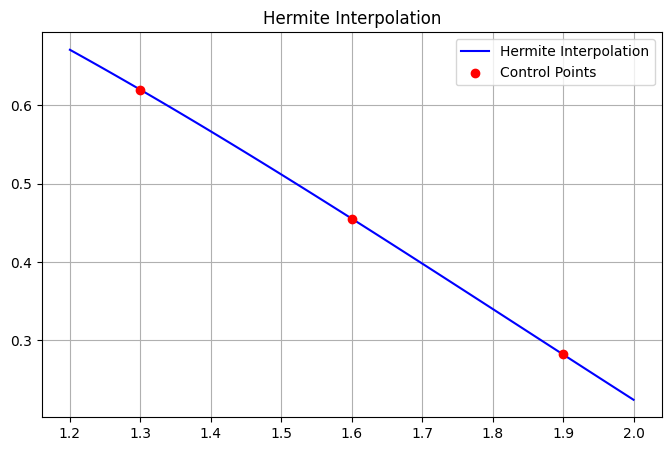

In [8]:
X = [1.3, 1.6, 1.9]
F = [0.6200860, 0.4554022, 0.2818186]
dF = [-0.5220232, -0.5698959, -0.5811571]
x = 1.5
poly = Hermite(F, dF, X)
poly(x)

# Generate x values for smooth curve
curve_x = np.linspace(1.2, 2.0, 100)
curve_y = np.array([poly(x) for x in curve_x])

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(curve_x, curve_y, label="Hermite Interpolation", color='blue')
plt.scatter(X, F, color='red', label="Control Points", zorder=3)
plt.title("Hermite Interpolation")
plt.legend()
plt.grid(True)
plt.show()

## Chapter 3.5 Cubic Spline Interpolation

### Natural Cubic Spline
Construct the cubic spline interpolant $S$ for the function $f$, defined at the numbers $x_0<x_1<\cdots<x_n$, satisfying $S''(x_0)=S''(x_n)=0$
where
$$ S(x)=S_j(x)=a_j+b_j(x-x_j)+c_j(x-x_j)^2+d_j(x-x_j)^3,x_j\leq x\leq x_{j+1}$$

In [9]:
import numpy as np
from typing import Union, List, Callable, Any
import matplotlib.pyplot as plt

def NaturalCubic(func: Union[Callable[[Union[float, int]], float],
                        np.ndarray[Union[float, int], Any],
                        List[Union[int, float]]],
                 x_: Union[np.ndarray[Union[float, int], Any], List[Union[int, float]]],
                 plot: bool = False
            ) -> np.ndarray[Union[float, int], Any]:
    '''
    Returns:
    - Numpy array with shape (len(x_) - 1, 4) where each row represents the coefficients (a, b, c, d)
      of a cubic spline segment, from the first to the last segment.
    '''
    n = len(x_)
    coef = np.zeros((4, n))
    f_call = callable(func)

    for idx in range(n):
        coef[0][idx] = func(x_[idx]) if f_call else func[idx]

    h = np.diff(x_)
    alpha = np.zeros((n))
    for idx in range(1, n - 1):
        diff = func(x_[idx + 1]) - func(x_[idx]) if f_call else func[idx + 1] - func[idx]
        diff_ = func(x_[idx]) - func(x_[idx - 1]) if f_call else func[idx] - func[idx - 1]
        alpha[idx] = (3 * diff / h[idx]) - (3 * diff_ / h[idx - 1])

    l = np.ones((n, ))
    mu = np.zeros((n, ))
    z = np.zeros((n, ))

    for idx in range(1, n - 1):
        l[idx] = 2 * (x_[idx + 1] - x_[idx - 1]) - h[idx - 1] * mu[idx - 1]
        mu[idx] = h[idx] / l[idx]
        z[idx] = (alpha[idx] - h[idx - 1] * z[idx - 1]) / l[idx]
    for jdx in range(n - 2, -1, -1):
        coef[2][jdx] = z[jdx] - mu[jdx] * coef[2][jdx + 1]
        coef[1][jdx] = (coef[0][jdx + 1] - coef[0][jdx]) / h[jdx] - h[jdx] * (coef[2][jdx + 1] + 2 * coef[2][jdx]) / 3
        coef[3][jdx] = (coef[2][jdx + 1] - coef[2][jdx]) / (3 * h[jdx])

    if plot:
        curve_x = np.linspace(x_[0], x_[-1], 100)
        curve_y = np.zeros(100)
        
        for i in range(n - 1):
            mask = (curve_x >= x_[i]) & (curve_x <= x_[i + 1])  # Ensure last point is included
            t = curve_x[mask] - x_[i]
            curve_y[mask] = (coef[0, i] + coef[1, i] * t + coef[2, i] * t**2 + coef[3, i] * t**3)

        curve_x[-1] = x_[-1]
        curve_y[-1] = coef[0, -1]

        plt.figure(figsize=(8, 5))
        plt.plot(curve_x, curve_y, label="Natural Cubic Spline", color='blue')
        plt.scatter(x_, coef[0, :n], color='red', label="Control Points", zorder=3)
        plt.title("Natural Cubic Spline Interpolation")
        plt.legend()
        plt.grid()
        plt.show()

    return coef[:, :n - 1].T

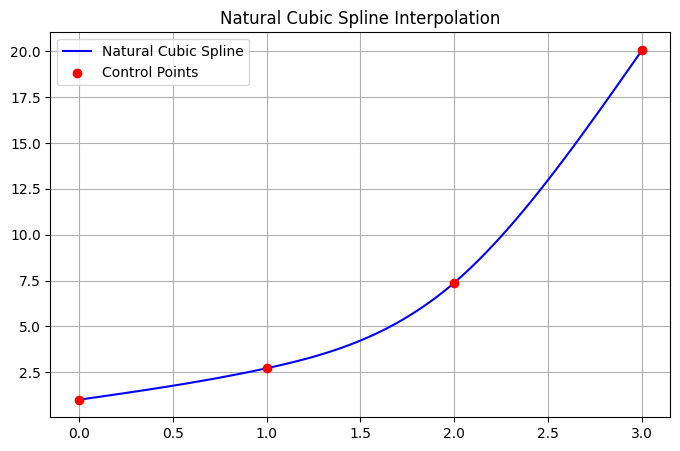

array([[ 1.        ,  1.46599761,  0.        ,  0.25228421],
       [ 2.71828183,  2.22285026,  0.75685264,  1.69107137],
       [ 7.3890561 ,  8.80976965,  5.83006675, -1.94335558]])

In [10]:
import math
F = [1, math.exp(1), math.exp(2), math.exp(3)]
X = [0, 1, 2, 3]
NaturalCubic(F, X, True)

### Clamped Cubic Spline
To construct the cubic spline interpolant $S$ for the function $f$ defined at the numbers $x_0<x_1<\cdots<x_n$, satisfying $S'(x_0)=f'(x_0)$ and $S'(x_n)=f'(x_n)$
where
$$ S(x)=S_j(x)=a_j+b_j(x-x_j)+c_j(x-x_j)^2+d_j(x-x_j)^3,x_j\leq x\leq x_{j+1}$$

In [11]:
def ClampedCubic(func: Union[Callable[[Union[float, int]], float],
                        np.ndarray[Union[float, int], Any],
                        List[Union[int, float]]],
                 dfunc: Union[Callable[[Union[float, int]], float],
                        np.ndarray[Union[float, int], Any],
                        List[Union[int, float]]],
                 x_: Union[np.ndarray[Union[float, int], Any], List[Union[int, float]]],
                 plot: bool = False
            ) -> np.ndarray[Union[float, int], Any]:
    '''
    Returns:
    - Numpy array with shape (len(x_) - 1, 4) where each row represents the coefficients (a, b, c, d)
      of a cubic spline segment, from the first to the last segment.
    '''
    n = len(x_)
    coef = np.zeros((4, n))
    f_call = callable(func)
    df_call = callable(dfunc)

    df = dfunc(x_[0]) if df_call else dfunc[0]
    df_ = dfunc(x_[n - 1]) if df_call else dfunc[1]

    for idx in range(n):
        coef[0][idx] = func(x_[idx]) if f_call else func[idx]

    h = np.diff(x_)
    alpha = np.zeros((n))
    alpha[0] = 3 * (coef[0][1] - coef[0][0]) / h[0] - 3 * df
    alpha[n - 1] = 3 * (df_ - (coef[0][n - 1] - coef[0][n - 2]) / h[n - 2])

    for idx in range(1, n - 1):
        diff = func(x_[idx + 1]) - func(x_[idx]) if f_call else func[idx + 1] - func[idx]
        diff_ = func(x_[idx]) - func(x_[idx - 1]) if f_call else func[idx] - func[idx - 1]
        alpha[idx] = (3 * diff / h[idx]) - (3 * diff_ / h[idx - 1])

    l = np.zeros((n, ))
    mu = np.zeros((n, ))
    z = np.zeros((n, ))
    l[0] = 2 * h[0]
    mu[0] = 0.5
    z[0] = alpha[0] / l[0]

    for idx in range(1, n - 1):
        l[idx] = 2 * (x_[idx + 1] - x_[idx - 1]) - h[idx - 1] * mu[idx - 1]
        mu[idx] = h[idx] / l[idx]
        z[idx] = (alpha[idx] - h[idx - 1] * z[idx - 1]) / l[idx]

    l[n - 1] = h[n - 2] * (2 - mu[n - 2])
    z[n - 1] = (alpha[n - 1] - h[n - 2] * z[n - 2]) / l[n - 1]
    coef[2][n - 1] = z[n - 1]

    for jdx in range(n - 2, -1, -1):
        coef[2][jdx] = z[jdx] - mu[jdx] * coef[2][jdx + 1]
        coef[1][jdx] = (coef[0][jdx + 1] - coef[0][jdx]) / h[jdx] - h[jdx] * (coef[2][jdx + 1] + 2 * coef[2][jdx]) / 3
        coef[3][jdx] = (coef[2][jdx + 1] - coef[2][jdx]) / (3 * h[jdx])
    
    if plot:
            curve_x = np.linspace(x_[0], x_[-1], 100)
            curve_y = np.zeros(100)
            
            for i in range(n - 1):
                mask = (curve_x >= x_[i]) & (curve_x <= x_[i + 1])  # Ensure last point is included
                t = curve_x[mask] - x_[i]
                curve_y[mask] = (coef[0, i] + coef[1, i] * t + coef[2, i] * t**2 + coef[3, i] * t**3)

            curve_x[-1] = x_[-1]
            curve_y[-1] = coef[0, -1]

            plt.figure(figsize=(8, 5))
            plt.plot(curve_x, curve_y, label="Clamped Cubic Spline", color='blue')
            plt.scatter(x_, coef[0, :n], color='red', label="Control Points", zorder=3)
            plt.title("Clamped Cubic Spline Interpolation")
            plt.legend()
            plt.grid()
            plt.show()

    return coef[:, :n - 1].T

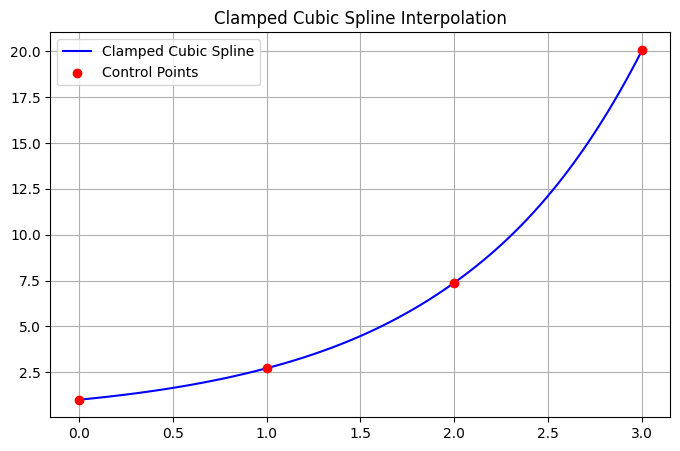

array([[1.        , 1.        , 0.4446825 , 0.27359933],
       [2.71828183, 2.71016299, 1.26548049, 0.69513079],
       [7.3890561 , 7.32651634, 3.35087286, 2.01909162]])

In [12]:
import math
F = [1, math.exp(1), math.exp(2), math.exp(3)]
dF = [1, math.exp(3)]
X = [0, 1, 2, 3]
ClampedCubic(F, dF, X, True)

In [13]:
# Just for comparison, x_, y_, x, y are obtained through modifying the two funcitons above to return
# curve_x and curve_y respectively.
# In this case, Clamped approximates better than Natural
# plt.figure(figsize=(8, 5))
# plt.plot(x_, y_, label="Natural Cubic Spline", color='red')
# plt.plot(x, y, label="Clamped Cubic Spline", color='blue')
# plt.plot(t := np.linspace(0, 3, 100), np.exp(t), label="Actual", color="yellow")
# plt.legend()
# plt.grid()

# Beyond the book

### Bezier Curve
A Bezier Curve $B$ of degree $n$ can be written in Bernstein form as follows:

$$B(t)=\sum_{i=0}^{n}c_i b_{i, n}(t)$$

where $b_{i, n}(t)=\binom{n}{i}(1-t)^{n-i}t^i$ and $t\in[0, 1]$


Order of Bezier Curve equals to number of control points - 1

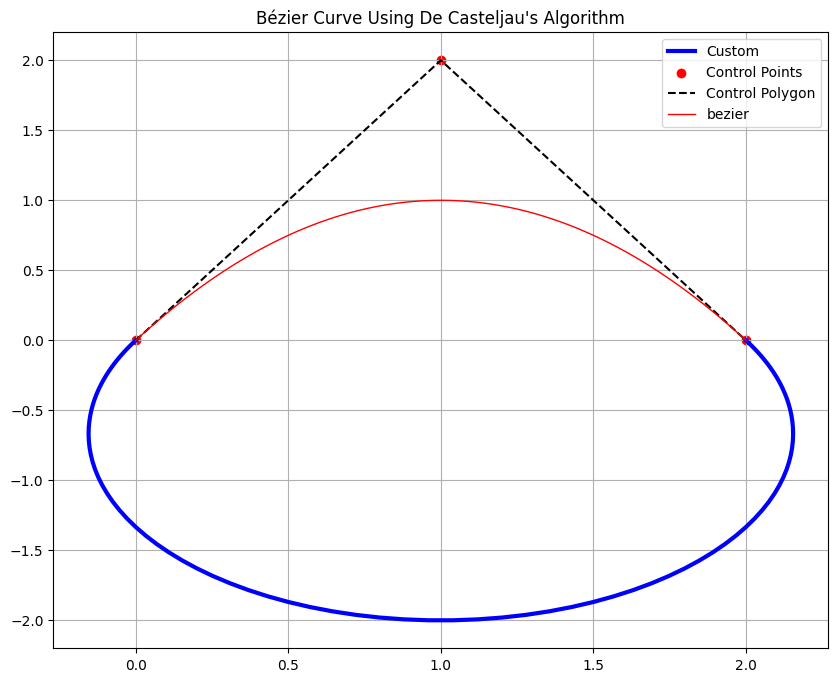

In [45]:
import numpy as np
import bezier

def deCasteljau(control_points: np.ndarray[Union[float, int]],
                t:float,
                weights: Union[None, np.ndarray[Union[float, int]]]=None
                ):
    # Ensure conversion to float to prevent the 'staircase effect' caused by integer-based plotting.
    beta = control_points.copy().astype(float)
    if weights is not None:
        w = weights[:, np.newaxis].astype(float)
        assert len(weights) == len(control_points)
        beta = np.hstack([beta * w, w])
    n = len(control_points)
    for idx in range(1, n):
        for jdx in range(n - idx):
            beta[jdx] = (1 - t) * beta[jdx] + t * beta[jdx + 1]
    return beta[0][:-1] / beta[0][-1] if weights is not None else beta[0]

control_points = np.array([
    (0, 0),   
    (1, 2),    
    (2, 0)
    # (3, 4),    
    # (4, 0),     
    # (-1, 0.5),    
    # (1, 2),    
    # (3, 6),    
    # (4, 8)
])
weights = np.array([
    1, -0.5, 1
])
t_values = np.linspace(0, 1, 100)
curve_points = np.array([deCasteljau(control_points, t, weights) for t in t_values])

plt.figure(figsize=(10, 8))
plt.plot(curve_points[:, 0], curve_points[:, 1], 'b-', label="Custom", lw=3)  # Bézier curve
plt.scatter(control_points[:, 0], control_points[:, 1], color='red', label="Control Points")  # Control points
plt.plot(control_points[:, 0], control_points[:, 1], 'k--', label="Control Polygon")  # Dashed control polygon

# Transpose to match Bezier library's expected shape (2, N)
control_points = control_points.T  
control_points_f = np.asfortranarray(control_points)
curve = bezier.Curve(control_points_f, degree=control_points.shape[1] - 1)
curve_points = curve.evaluate_multi(t_values.T)
plt.plot(curve_points[0, :], curve_points[1, :], 'r-', label="bezier", lw=1)  # Bézier curve

plt.legend()
plt.title("Bézier Curve Using De Casteljau's Algorithm")
plt.grid()
plt.show()

### B-Spline
Given $m+1$ control points and order $k$, B-Spline is defined as follow:
$$S(t)=\sum_{i=0}^{m}c_i N_{i, k}(t)$$

The basis function $N_{i, k}(t)$ defined on $m+k+1$ knots, $t_i$.

#### Cox-De Boor Recursion Formula

The Cox-De Boor ***recursion formula*** provides a method to calculate the B-spline basis functions of degree $k$. 


#### Base Case

For $k=0$, the basis functions results in a one-hot encoding vector with a value of $1$.

$$
N_{i,0}(x) = 
   \begin{cases} 
   1 & \text{if } t_i \leq x < t_{i+1} \\
   0 & \text{otherwise}
   \end{cases}
$$

where $i \in \{0, 1, 2, ..., m - 1\}$, 


#### Recursive Step

The subsequent cases results in features described as follows

$$ N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x) $$

Consider $k=1$, from the second term in the equation, we observe that $N_{i+1, k-1}$ is needed, but we do not define $N_{m, k-1}$ but only until $N_{m-1, k-1}$. Therefore, the range of $i$ becomes $i \in \{0, 1, 2, ..., m-2\}$. We can see that when $k$ increases by $1$, the range of $i$ will decrease by $1$ at the same time. The next line concludes this observation.

For $k$ th order, $i \in \{0, 1, 2, ..., m-k-1\}$, resulting in a total of $m-k$ basis functions. By using syntatic sugar in Python this can be achieved through $t[:-(k+1)]$ where $t$ is the knot array

For control points in $n$-dimensional space, apply the B-spline separately to each dimension and gather the results to construct the final curve.

#### Different Curves and Knots ([Good Place to Play](https://nurbscalculator.in/))
Given knots = $[u_0, u_1\cdots, u_{m}, u_{m+1}]$, order $k$, control points = $[p_0, p_1\cdots p_n]$, where $m=n + 1 + k$
- [Open](https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-curve-open.html)
   - Uniform knots
   - Only defined on interval $[u_k, u_{m - k}]$
      - Achieved this through clipping the inputs.
- [Clamped](https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-curve-open.html)
   - Repeat the starting and ending knots by $k + 1$
   - The middle knots are uniform
- [Close](https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-curve-closed.html)
   - Wrap the first $k$ and last $k$ control points. More precisely, let $p_0= p_{n-k+1}, p_1 = p_{n-k+2},\cdots, p_{p-2} = p_{n-1}, p_{p-1} = p_{n}$
      - Uniform knots
      - Only defined on interval $[u_k, u_{m - k}]$. However in implementation, we do not clip the input since wrapping the control points produce same effect.
   - Wrap knots (Not recommend, in most of the implementation, the knots are assumed to be non-decreasing order)
      

In [46]:
import numpy as np

def deBoor(x, knots, k, is_clamped=None, is_wrapped_knot=None):
    """
    Computes B-spline basis functions using the De Boor-Cox recursion formula not De Boor algorithm.
    
    Parameters:
    - x (np.array): Evaluation points (1D array).
    - knots (np.array): knots vector (1D array).
    - k (int): Order of the B-spline.
    
    Returns:
    - basis (torch.Tensor): Tensor of shape (len(x), len(knots) - k - 1) containing B-spline basis values.
    """
    # Each column of basis represents the values of one of the basis functions of order k, evaluated at each x.
    # For order k, there will be (len(knots) - k - 1) basis functions, so the shape of basis is keep changing in each iteration
    x = np.expand_dims(x, axis=1).astype(float)
    knots = np.expand_dims(knots, axis=0).astype(float)
    
    # 0_th order basis function ---> (len(x), ken(knots) - 1)
    basis = ((x >= knots[:, :-1]) & (x < knots[:, 1:])).astype(float)
    if is_clamped:
        idx = np.where(basis[:, -k - 1] == 1)[0][0]
        basis[idx:, -k - 1] = 1
    if is_wrapped_knot:
        idx = np.where(basis[:, -k - 2] == 1)[0][-1]
        basis[idx + 1, -k - 1] = 1

    for kdx in range(1, k + 1):

        # i index in the following represents the i_th knot or i_th order k basis functions, therefore, when discussing about i
        # the indexing will affect on the columns of knots and basis.

        # Current t_i correspond to knots[:, :len(knots) - k - 1] since when order k, i range from 0 to len(knots) - k - 1.
        # By syntatic sugar in Python, the index can be change to knots[:, -(k + 1)].
        # For t_i+k, just imagine shifting t_i to right by k, then
        # it bceoms knots[:, 0 + k:-k - 1 + k] ---> knots[:, k:-1]
        left_numerator = x - knots[:, :-(kdx + 1)]  
        left_denominator = knots[:, kdx:-1] - knots[:, :-(kdx + 1)]

        # For t_i+k+1, just imagine shifting t_i+k to right by 1, then
        # it bceoms knots[:, k + 1:-1 + 1] ---> knots[:, k:]
        # For t_i+1, just imagine shifting t_i to right by 1 then, it will be knots[:, 0 + 1:-k - 1 + 1] ---> knots[:, 1:-k].
        right_numerator = knots[:, kdx + 1:] - x 
        right_denominator = knots[:, kdx + 1:] - knots[:, 1:-kdx]  

        left_denominator[left_denominator == 0] = 1
        right_denominator[right_denominator == 0] = 1

        # For N_{i, k - 1}, since i range from 0 to len(knots) - k - 1 and current basis having shape (len(x), len(knots) - (k - 1) - 1)
        # equals to (len(x), len(knots) - k), therefore, we will just take all the elements in basis except the last column.
        # For N_{i + 1, k - 1}, imagine shifting N_{i, k - 1} to right by 1, i will be ranged from 1 to len(knots) - k.
        left_term = (left_numerator / left_denominator) * basis[:, :-1]
        right_term = (right_numerator / right_denominator) * basis[:, 1:]

        basis = left_term + right_term
    
    return basis

def BSplineND(x, knots, control_points, k, weights=None):
    is_clamped = np.all(knots[:k] == knots[0]) and np.all(knots[-k - 1:] == knots[-1])
    is_wrapped_knot = False
    # is_wrapped_knot = np.all(knots[:k + 2] == knots[len(control_points) - 1:])
    
    m = len(knots) - k - 1
    assert (m >= k + 1) and (len(control_points) >= m)
    knots_ = knots.copy()
    x_ = x.copy()
    if (not is_clamped) and (not is_wrapped_knot):
        x_[x_ < knots_[k]] = np.nan
        x_[x_ > knots_[-k - 1]] = np.nan
    # if is_wrapped_knot:
    #     knots_[len(control_points) - 1:] = 0
    basis = deBoor(x_, knots_, k, is_clamped, is_wrapped_knot)
    if weights is not None:
        weights = weights[:m]
        weighted_basis = basis * weights
        denominator = np.sum(weighted_basis, axis=1, keepdims=True)
        basis = weighted_basis / denominator
    return [(basis @ control_points[:m, idx]) for idx in range(control_points.shape[1])]

Remark: The computation of weighted or rational version for both _Bezier_ and _B-Spline_ Curves are equivalent with one using projection and perspective division while another one implements same logic from the formula.

In [47]:
from scipy.interpolate import BSpline as sciBSpline

def plot_comparison(knots, control_points, p, weights=None, include_scipy=True, title="", num_p=1000):
    t = np.linspace(0, 1, num_p)
    px, py = control_points[:, 0], control_points[:, 1]
    plt.figure(figsize=(8, 6))
    if include_scipy:
        bspline_x = sciBSpline(knots, px, p, extrapolate=False)
        bspline_y = sciBSpline(knots, py, p, extrapolate=False)
        curve_x = bspline_x(t)
        curve_y = bspline_y(t)
        knot_x = bspline_x(knots)
        knot_y = bspline_y(knots)
        plt.plot(curve_x, curve_y, 'r-', label="Scipy", lw=3)
        plt.scatter(knot_x, knot_y, color='red', marker='s', label="Scipy Knot Points")

    curve_x, curve_y = BSplineND(t, knots, control_points, p, weights)
    knot_x, knot_y = BSplineND(knots, knots, control_points, p, weights)
    plt.plot(curve_x, curve_y, 'b', label="Custom", lw=2)
    plt.scatter(knot_x, knot_y, color='black', marker='x', label="Custom Knot Points")
    plt.plot(control_points[:, 0], control_points[:, 1], 'ko--', label='Control Points')
    # print(knot_x)
    # print(knot_y)
    # print(np.unique(knot_x), np.unique(knot_y))
    plt.grid()
    plt.legend()
    plt.title(title)


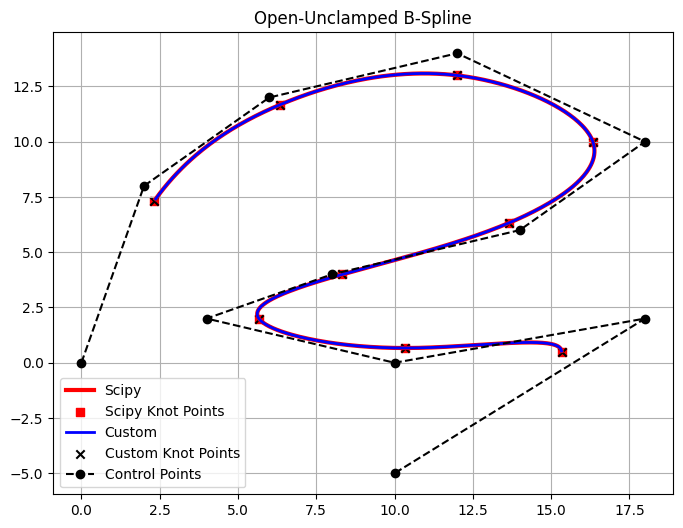

In [48]:
control_points = np.array([
    [0, 0], [2, 8], [6, 12], [12, 14], [18, 10],
    [14, 6], [8, 4], [4, 2], [10, 0], [18, 2], [10, -5]
])
n = len(control_points) - 1
p = 3
m = n + p + 1
knots = np.linspace(0, 1, m + 1)
plot_comparison(knots, control_points, p, None, True, "Open-Unclamped B-Spline")

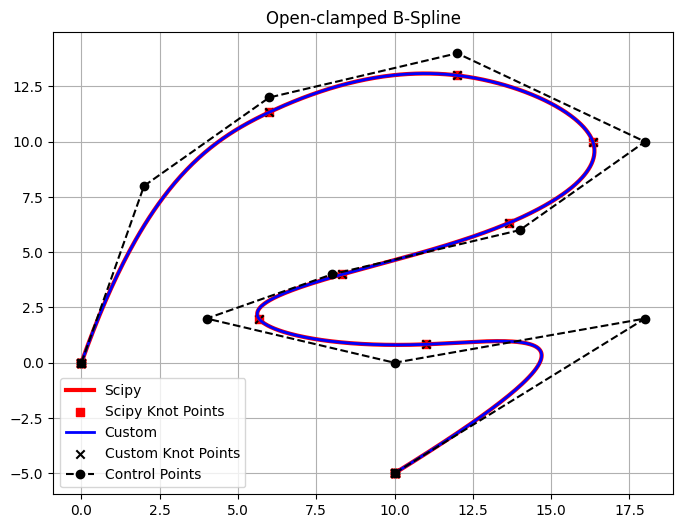

In [49]:
control_points = np.array([
    [0, 0], [2, 8], [6, 12], [12, 14], [18, 10],
    [14, 6], [8, 4], [4, 2], [10, 0], [18, 2], [10, -5]
])
n = len(control_points) - 1
p = 3
m = n + p + 1
# Clamped knot : p + 1 repeated knots at start and end, a 1D array with m + 1 elements
knots = np.concatenate((
    np.zeros(p + 1), 
    np.array([idx / (m - 2 * p) for idx in range(1, m - 2 * p)]),
    np.ones(p + 1)  
))
plot_comparison(knots, control_points, p, None, True, "Open-clamped B-Spline")

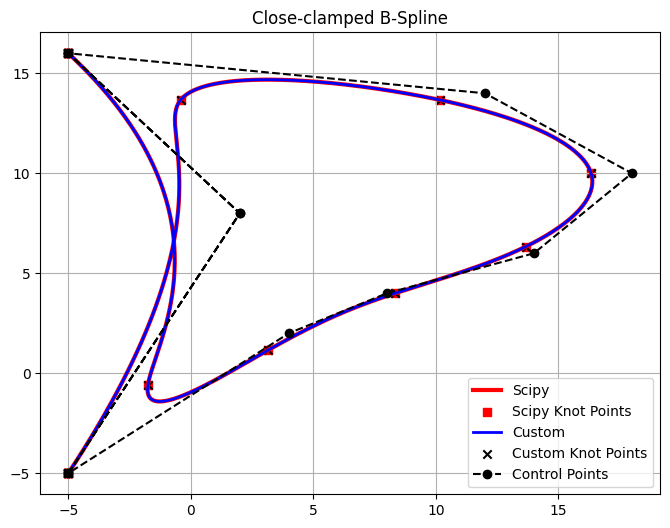

In [50]:
# Wrap control points
control_points = np.array([
    [-5, -5], [2, 8], [-5, 16], [12, 14], [18, 10],
    [14, 6], [8, 4], [4, 2], 
    # Wrapped control points
    [-5, -5], [2, 8], [-5, 16]
])

n = len(control_points) - 1
p = 3
m = n + p + 1

knots = np.concatenate((
    np.zeros(p + 1), 
    np.array([idx / (m - 2 * p) for idx in range(1, m - 2 * p)]),
    np.ones(p + 1)  
))

plot_comparison(knots, control_points, p, None, True, "Close-clamped B-Spline")

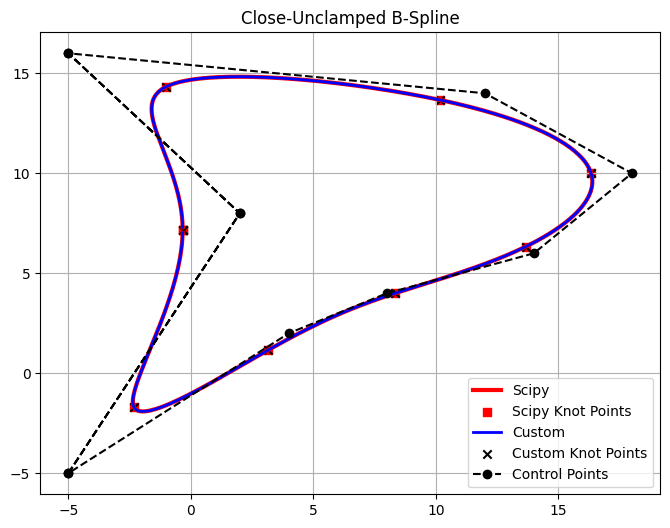

In [51]:
# Wrap control points
control_points = np.array([
    [-5, -5], [2, 8], [-5, 16], [12, 14], [18, 10],
    [14, 6], [8, 4], [4, 2], 
    # Wrapped control points
    [-5, -5], [2, 8], [-5, 16]
])

n = len(control_points) - 1
p = 3
m = n + p + 1

knots = np.linspace(0, 1, m + 1)
plot_comparison(knots, control_points, p, None, True, "Close-Unclamped B-Spline")

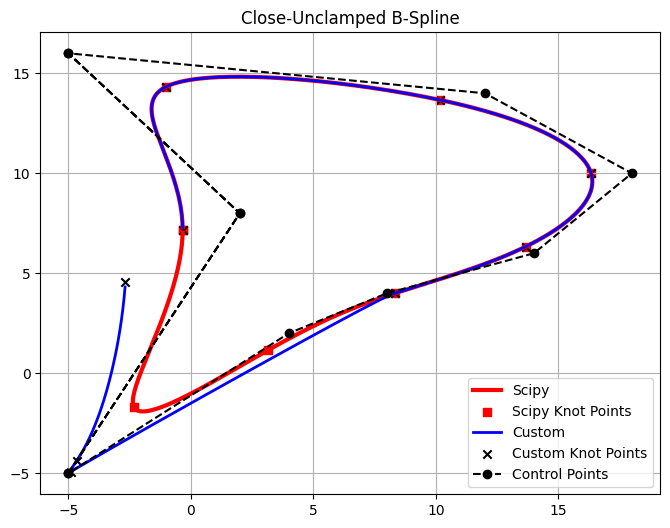

In [52]:
# Wrap control points
control_points = np.array([
    [-5, -5], [2, 8], [-5, 16], [12, 14], [18, 10],
    [14, 6], [8, 4], [4, 2], 
    # Wrapped control points
    [-5, -5], [2, 8], [-5, 16]
])

n = len(control_points) - 1
p = 3
m = n + p + 1

knots = np.linspace(0, 1, m + 1)
weights = np.ones(control_points.shape[0])
weights[-3:] = np.array([500, 100, 300])
plot_comparison(knots, control_points, p, weights, True, "Close-Unclamped B-Spline", num_p=1000)

In [53]:
# Wrap knots (Not recommend) (Still having bugs)
# control_points = np.array([
#     [-5, -5], [2, 8], [-5, 16], [12, 14], [18, 10],
#     [14, 6], [8, 4], [4, 2],
# ])

# n = len(control_points) - 1
# p = 3

# # Append starting point to the end and specific axis to prevent the function flatten the array
# control_points = np.append(control_points, [control_points[0]], axis=0)

# knots = np.linspace(0, 1, n + 1)
# print(len(knots), knots)
# knots = np.append(knots, knots[:p + 2])
# print(len(knots), knots)
# plot_comparison(knots, control_points, p, None, False, "Close-clamped B-Spline", 50)